In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
img1 = cv2.imread("fp/input_image_carbon (2).png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread("sp/input_image_carbon(1).png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
print(img1.shape) 
print(img2.shape) 

(730, 730, 3)
(767, 767, 3)


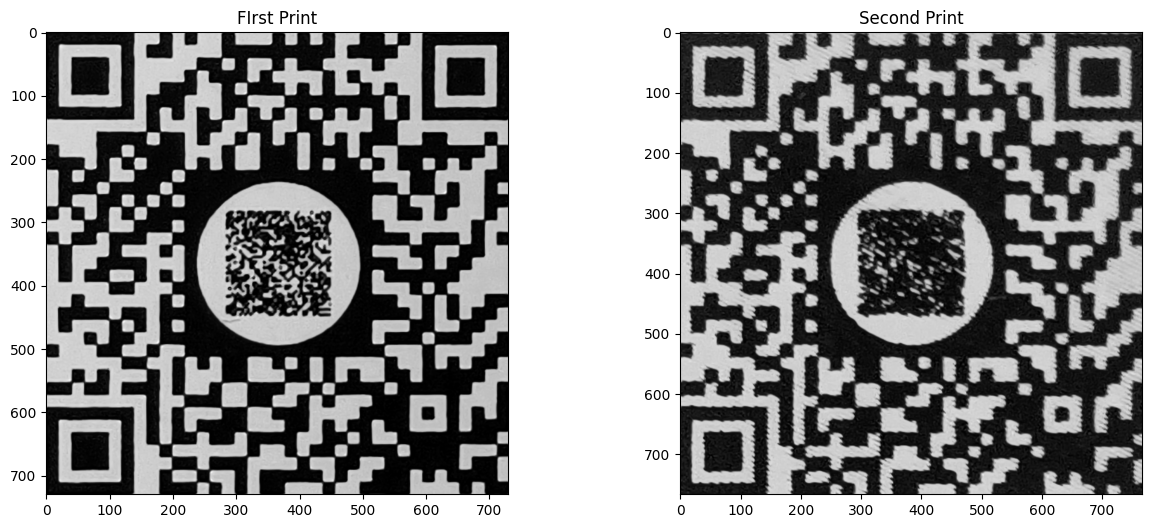

In [50]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.imshow(img1)
plt.title('FIrst Print')

plt.subplot(122)
plt.imshow(img2)
plt.title('Second Print')

plt.show()

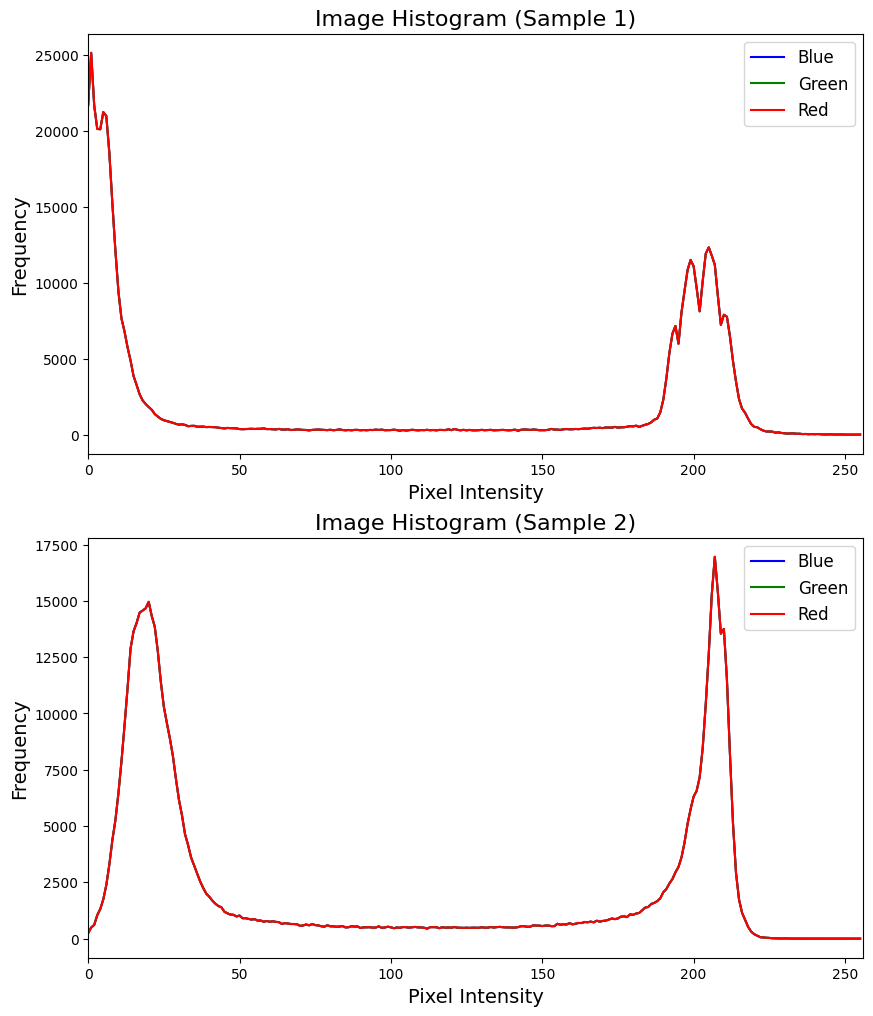

In [60]:
colors = ('b', 'g', 'r')  # OpenCV loads in BGR format
plt.figure(figsize=(10, 12))

plt.subplot(211)
for i, color in enumerate(colors):
    hist1 = cv2.calcHist([img1], [i], None, [256], [0, 256])
    plt.plot(hist1, color=color)
    plt.xlim([0, 256])
plt.title("Image Histogram (Sample 1)", fontsize=16)
plt.xlabel("Pixel Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(['Blue', 'Green', 'Red'], fontsize=12)

plt.subplot(212)
for i, color in enumerate(colors):
    hist2 = cv2.calcHist([img2], [i], None, [256], [0, 256])
    plt.plot(hist2, color=color)
    plt.xlim([0, 256])
plt.title("Image Histogram (Sample 2)", fontsize=16)
plt.xlabel("Pixel Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(['Blue', 'Green', 'Red'], fontsize=12)

plt.show()

In [7]:
# Path to the 'data' folder
data_folder = "data"


df = pd.read_csv("feature_data.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            200 non-null    int64  
 1   filename         200 non-null    object 
 2   label            200 non-null    int64  
 3   entropy          200 non-null    float64
 4   kurtosis         200 non-null    float64
 5   variance         200 non-null    float64
 6   height           200 non-null    int64  
 7   width            200 non-null    int64  
 8   area             200 non-null    int64  
 9   peak_separation  200 non-null    int64  
 10  snr              200 non-null    float64
 11  edge_density     200 non-null    float64
 12  blur_level       200 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 20.4+ KB


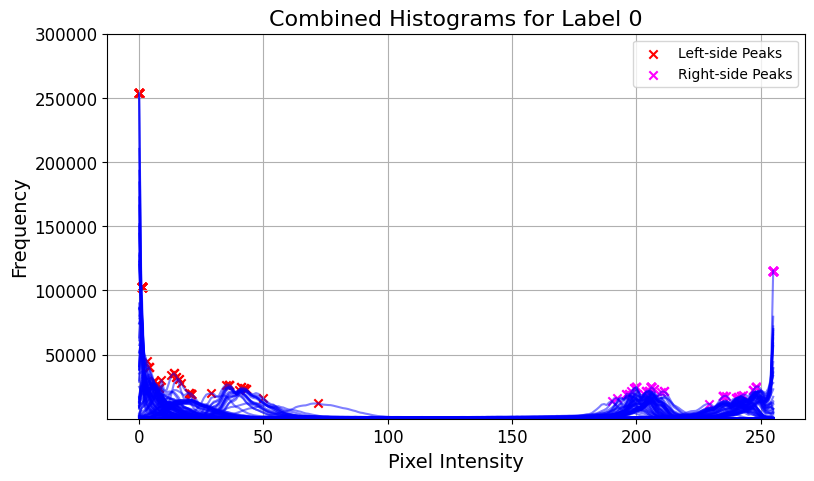

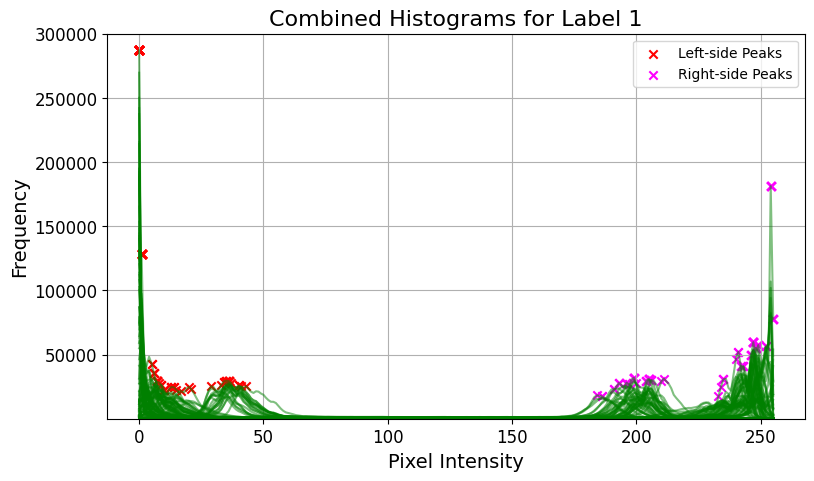

In [63]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_two_peak_separation(image_path):
    """
    Detect peaks using slope changes (first derivative) and compute the separation of the top two peaks.
    Handles edge cases for first (0) and last (255) intensity bins.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")

    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    padded_hist = np.pad(hist, (1, 1), mode='constant', constant_values=(0, 0))
    slope = np.diff(padded_hist)  

    peaks = np.where((slope[:-1] > 0) & (slope[1:] <= 0))[0]

    if len(peaks) < 2:
        return None, hist, []

    first_half_peaks = [p for p in peaks if p < 128]  
    second_half_peaks = [p for p in peaks if p >= 128]  

    if not first_half_peaks or not second_half_peaks:
        return None, hist, []

    first_peak = max(first_half_peaks, key=lambda p: hist[p])
    second_peak = max(second_half_peaks, key=lambda p: hist[p])
    peak_separation = abs(second_peak - first_peak)

    return peak_separation, hist, [first_peak, second_peak]

# Store histograms and peaks for all images
histograms_label_0 = []
histograms_label_1 = []
peaks_label_0 = []
peaks_label_1 = []

for idx, row in df.iterrows():
    image_path = os.path.join(data_folder, row["filename"])
    peak_sep, hist, peaks = compute_two_peak_separation(image_path)

    # Store for combined plots
    if row["label"] == 0:
        histograms_label_0.append(hist)
        peaks_label_0.extend(peaks)
    else:
        histograms_label_1.append(hist)
        peaks_label_1.extend(peaks)

# Plot combined histograms for label 0
plt.figure(figsize=(9, 5))
for hist in histograms_label_0:
    plt.plot(hist, alpha=0.5, color='blue')
peak_values_0 = [max(hist[p] for hist in histograms_label_0) for p in peaks_label_0]
first_half_peaks_0 = [p for p in peaks_label_0 if p < 128]
second_half_peaks_0 = [p for p in peaks_label_0 if p >= 128]

first_half_peak_values_0 = [max(hist[p] for hist in histograms_label_0) for p in first_half_peaks_0]
second_half_peak_values_0 = [max(hist[p] for hist in histograms_label_0) for p in second_half_peaks_0]

plt.scatter(first_half_peaks_0, first_half_peak_values_0, color='red', marker='x', label="Left-side Peaks")
plt.scatter(second_half_peaks_0, second_half_peak_values_0, color='magenta', marker='x', label="Right-side Peaks")
plt.ylim(1, 300000)
plt.title("Combined Histograms for Label 0", fontsize=16)
plt.xlabel("Pixel Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# Plot combined histograms for label 1
plt.figure(figsize=(9, 5))
for hist in histograms_label_1:
    plt.plot(hist, alpha=0.5, color='green')
peak_values_1 = [max(hist[p] for hist in histograms_label_1) for p in peaks_label_1]
first_half_peaks_1 = [p for p in peaks_label_1 if p < 128]
second_half_peaks_1 = [p for p in peaks_label_1 if p >= 128]

first_half_peak_values_1 = [max(hist[p] for hist in histograms_label_1) for p in first_half_peaks_1]
second_half_peak_values_1 = [max(hist[p] for hist in histograms_label_1) for p in second_half_peaks_1]

plt.scatter(first_half_peaks_1, first_half_peak_values_1, color='red', marker='x', label="Left-side Peaks")
plt.scatter(second_half_peaks_1, second_half_peak_values_1, color='magenta', marker='x', label="Right-side Peaks")
plt.ylim(1, 300000)
plt.title("Combined Histograms for Label 1", fontsize=16)
plt.xlabel("Pixel Intensity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.legend()
plt.show()
